<a href="https://colab.research.google.com/github/HarmanDotpy/ML-Assignment2/blob/main/Q3_1_unbalanced_3_classes_MNIST_PyTorch_CNN_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MNIST Classification 
Convolutional Neural Networks, using PYTORCH

In [1]:
# %%shell
# mkdir DATA_STORE
# mkdir MODEL_STORE

In [58]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sb
import numpy as np

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [60]:
def performance_metrics_multiclass(y_pred_test, y_test, num_class, disp_conf = True):
    '''gives the TPR, FPR, acc, precision, recall and F1 score for all classes by comparing the 2 input arrays'''
    #First we calculate the confusion matrix of size num_class*num_class
    #NOTE: Y axis of matrix will be predicted class and x axis wll be true class
    conf_mat = np.zeros((num_class, num_class))
    
    for i in range(num_class):
        for j in range(num_class):
            conf_mat[i, j] = np.logical_and(y_pred_test == i, y_test ==j).sum()
    # Calculating precision, recall, F1 Score for each class
    colnames = ['class', 'Precision', 'Recall', 'F1']
    df = pd.DataFrame(columns = colnames)
    for i in range(num_class):
        TP = conf_mat[i, i]
        FP = conf_mat[i].sum() - conf_mat[i, i]
        TN = conf_mat.sum() - conf_mat[i].sum() - conf_mat[:, i].sum() +  conf_mat[i, i]
        FN = conf_mat[:, i].sum() - conf_mat[i, i]
        P = round((TP)/(TP+FP), 5)
        R = round((TP)/(TP+FN), 5)
        F1 = round(2*P*R/(P+R), 5)
        df = df.append({'class':categories[i], 'Precision':P, 'Recall':R, 'F1':F1 }, ignore_index = True)
    macroF1 = round(df['F1'].mean(), 5)
    accuracy = round((y_pred_test==y_test).mean(), 5)
    
    # NOTE : returning the transpose of the confusion matricx to get true labels on the y axis
    conf_mat = conf_mat.T
    # NORMALIZING the confusion matrix
    conf_mat = np.around(conf_mat/(conf_mat.sum(axis = 1)), decimals = 5)
    
    
    #PLot the matrix if disp_conf = True
    if(disp_conf == True):
        ax = sb.heatmap(conf_mat, vmin = 0, vmax = 1, cmap = sb.light_palette("seagreen", as_cmap=True), xticklabels = categories, yticklabels = categories, annot = True, annot_kws={"size": 12}, fmt=".3f")
    #     ax.figure.axes[-1].yaxis.label.set_size(12)
        plt.xlabel('Predicted Labels', fontsize = 14)
        plt.ylabel('True Labels', fontsize = 14)
        plt.tick_params(axis='both', labelsize=10)
        return conf_mat, df, macroF1, accuracy, plt
    
    return conf_mat, df, macroF1, accuracy

In [61]:
# model hyperparameters
batch_size = 64
num_epochs = 20
num_classes = 3
learning_rate = 0.001
categories = ['0', '1', '2']

# transforms for the datasets
# MNIST is single channeled, for , eg CIFAR dataset , the normalization has to use mean and variance of all three ie Red, Blue and Green
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

### Using Just class 0, 1, 2 for Q3 part 1 of the assignment


In [62]:
def choose_first(bool_array, num):
  # bool array has true and false. this function returns a bool array of same size having first 'num' tru's intact and the rest made to false
  num_true = 0
  for i in range(len(bool_array)):
    if(bool_array[i]==True):
      num_true+=1
    if(num_true >= num):
      k=i
      while(k<len(bool_array)):
        bool_array[k]=False
        k+=1
      break
    
  return bool_array


def get_unbalanced_data(data, c1, c2, c3, r1, r2, r3):
  #get c1, c2, c3 in ratio r1:r2:r3
  max = (data.targets == c1).sum()
  idx_c1 = (data.targets == c1)
  idx_c2 = choose_first((data.targets == c2), max*r2//(r1))
  idx_c3 = choose_first((data.targets == c3), max*r3//(r1))
  idx = idx_c1 + idx_c2 + idx_c3
  data.targets = data.targets[idx]
  data.data = data.data[idx]
  
  print(idx_c1.sum(), idx_c2.sum(), idx_c3.sum())

  return data

  
#making dataset called dat having 70k images
train_data = torchvision.datasets.MNIST(root ='./DATA_STORE', train = True, transform = trans, download = True)
test_data = torchvision.datasets.MNIST(root = './DATA_STORE', train = False, transform = trans, download = True)

# chooseing the 3 classes and making the final train and test dataset
#choosing class 0:1:2 = 70:25:5 = 1:5/14:1/14
train_data = get_unbalanced_data(train_data, 0, 1, 2, 70, 25, 5)
test_data = get_unbalanced_data(test_data, 0, 1, 2, 70, 70, 70)

print(train_data)
print(test_data)
# print(len(test_data))
# # load into dataloader
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = len(test_data), shuffle = False)

tensor(5923) tensor(2114) tensor(422)
tensor(980) tensor(979) tensor(979)
Dataset MNIST
    Number of datapoints: 8459
    Root location: ./DATA_STORE
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 2938
    Root location: ./DATA_STORE
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [63]:
# print(train_loader.dataset)

In [64]:
# print(test_data.targets)
# print(test_data.targets.shape)
# print(test_data.data.shape)
# print(train_data.targets)
# print(train_data.targets.shape)
# print(train_data.data.shape)


In [65]:
# our class inherits from the torch.nn.Module class 

# nn.Conv2d(input channels, output channels, Kernel size, stride, padding)
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2,stride = 2)
        )
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, 64,kernel_size = 5, stride = 1, padding = 2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(7*7*64,1000)
    self.fc2 = nn.Linear(1000, 3)
    # self.softmax = nn.Softmax(dim = 0)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0), -1)    
    out = self.drop_out(out)
    out = self.fc1(out)
    out = self.fc2(out)
    # out = self.softmax(out)

    return out

class simplenet(nn.Module):
  def __init__(self):
    super(simplenet, self).__init__()
    self.fc1 = nn.Linear(28*28,100)
    self.fc2 = nn.Linear(100, 3)
    # self.softmax = nn.Softmax(dim = 0)

  def forward(self, x):
    out = x.reshape(x.size(0), -1)    
    out = self.fc1(out)
    out = self.fc2(out)
    # out = self.softmax(out)

    return out  

# Feedforward Net with Cross Entropy Loss simple without any wegihting

In [85]:
#  initializing the model
# model = ConvNet()
model = simplenet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [86]:
# Training the model
totalsteps = len(train_loader)
losslist = []
accuracylist = []
num_epochs = 5
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    # print(labels)
    outputs = model(images)
    loss = criterion(outputs, labels)
    losslist.append(loss.item())

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if((i + 1) % 50 == 0):
    # if(True):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))


Epoch [1/5], Step [50/133], Loss: 0.0325, Accuracy: 100.00%
Epoch [1/5], Step [100/133], Loss: 0.0086, Accuracy: 100.00%
Epoch [2/5], Step [50/133], Loss: 0.0093, Accuracy: 100.00%
Epoch [2/5], Step [100/133], Loss: 0.0030, Accuracy: 100.00%
Epoch [3/5], Step [50/133], Loss: 0.0046, Accuracy: 100.00%
Epoch [3/5], Step [100/133], Loss: 0.0005, Accuracy: 100.00%
Epoch [4/5], Step [50/133], Loss: 0.0047, Accuracy: 100.00%
Epoch [4/5], Step [100/133], Loss: 0.0151, Accuracy: 98.44%
Epoch [5/5], Step [50/133], Loss: 0.0222, Accuracy: 98.44%
Epoch [5/5], Step [100/133], Loss: 0.0079, Accuracy: 100.00%


[[1.      0.      0.     ]
 [0.      0.99591 0.00409]
 [0.02959 0.03371 0.93667]]
  class  Precision   Recall       F1
0     0    0.97126  1.00000  0.98542
1     1    0.96726  0.99591  0.98138
2     2    0.99566  0.93667  0.96526
macroF1 = 0.97735, accuracy = 0.97754
Test Accuracy for 2938 test images = 97.75357385976855 %


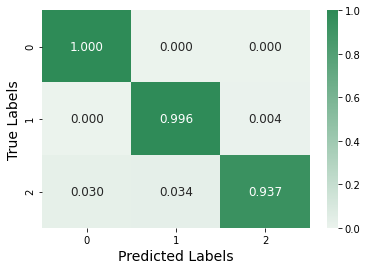

In [87]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # The following loop runs only for 1 time as the batch size for test loader is the size of number of test images only
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]

    confmat, df, macrof1, acc, plt = performance_metrics_multiclass(predicted.to('cpu').numpy(), labels.to('cpu').numpy(), num_classes)
    print(confmat)
    print(df)
    print('macroF1 = {}, accuracy = {}'.format(macrof1, acc))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(len(test_loader.dataset) ,(correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')


  ##Performance metrics


GRAPH PLOTS


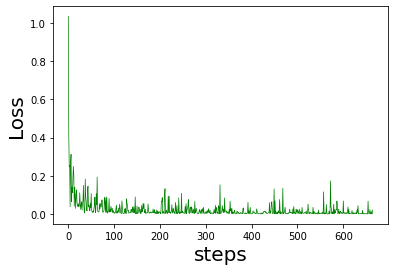

In [88]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.7 )
plt.xlabel('steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)
# plt.plot(accuracylist, color = 'red', linewidth = 0.7)
# plt.xlim(0,700)
# plt.ylim(0,1.05)
plt.show()


# SOME RANDOM EXPERIMENTS 
Using test data images

taking every 50th image from the test dataset :


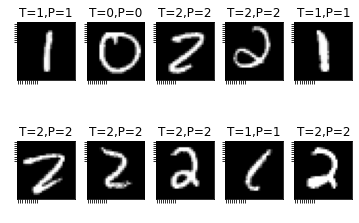

The output predictions by the model are : 
[1. 0. 2. 2. 1. 2. 2. 2. 1. 2.]


In [90]:
import numpy as np
fig = plt.figure()
rows = 2
columns = 5
count1 = 0
count2 = 1
predicted = np.zeros(10)
every = 50
print('taking every {}th image from the test dataset :'.format(every))
for i, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  imgs = images.to('cpu')

  for j in range(images.size(0)):
    if((j+1) % 50 ==0 and count1<10):
      if(count2 % 50 == 0):
        output = model(images)
        predictions = torch.max(output.data,1)[1]
        predicted[count1] = predictions[j].item()
        a = fig.add_subplot(rows, columns, count1+1)
        a.title.set_text('T={},P={}'.format(labels[j].item(), predictions[j].item()))
        # a.set_xticks()
        # a.set_title(labels[j].item(), color ='white')
        plt.imshow(np.array(imgs[j]).reshape((28,28)), cmap = 'gray')
        x = np.arange(10)
        y = np.arange(10)
        plt.xticks(x, " ")
        plt.yticks(y, " ")
        count1+=1

    count2+=1
plt.show()
print('The output predictions by the model are : ')
print(predicted)


taking every 50th image from the test dataset :


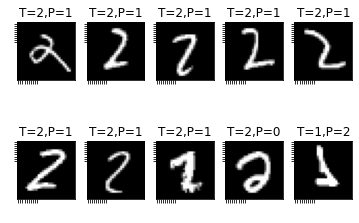

The output predictions by the model are : 
[1. 1. 1. 1. 1. 1. 1. 1. 0. 2.]


In [91]:
import numpy as np
fig = plt.figure()
rows = 2
columns = 5
count1 = 0
count2 = 1
predicted = np.zeros(10)
every = 50
print('taking every {}th image from the test dataset :'.format(every))
for i, (images, labels) in enumerate(test_loader):
  images, labels = images.to(device), labels.to(device)
  imgs = images.to('cpu')
  output = model(images)
  predictions = torch.max(output.data,1)[1]
  # print(output)
  for j in range(images.size(0)):
    if(predictions[j] != labels[j] and count1<10):
      predicted[count1] = predictions[j].item()
      a = fig.add_subplot(rows, columns, count1+1)
      a.title.set_text('T={},P={}'.format(labels[j].item(), predictions[j].item()))
      # a.set_xticks()
      # a.set_title(labels[j].item(), color ='white')
      plt.imshow(np.array(imgs[j]).reshape((28,28)), cmap = 'gray')
      x = np.arange(10)
      y = np.arange(10)
      plt.xticks(x, " ")
      plt.yticks(y, " ")
      count1+=1


# plt.savefig('./Q3.1_wrong_classified.jpeg', dpi = 300, bbox_inches = 'tight')
plt.show()
print('The output predictions by the model are : ')
print(predicted[:count1])

# Feedforward Net with Cross Entropy Loss with weighting

In [102]:
#  initializing the model
# model = ConvNet()
model = simplenet()
model = model.to(device)
criterion = nn.CrossEntropyLoss(weight = torch.tensor([1, 14/5, 14]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [103]:
# Training the model
totalsteps = len(train_loader)
losslist = []
accuracylist = []
num_epochs = 5
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    outputs = model(images)
    loss = criterion(outputs, labels)
    losslist.append(loss.item())

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if((i + 1) % 50 == 0):
    # if(True):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))


torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 2

KeyboardInterrupt: ignored

[[0.99694 0.00306 0.     ]
 [0.      0.99694 0.00306]
 [0.02551 0.06742 0.90705]]
  class  Precision   Recall       F1
0     0    0.97505  0.99694  0.98587
1     1    0.93397  0.99694  0.96443
2     2    0.99663  0.90705  0.94973
macroF1 = 0.96668, accuracy = 0.96698
Test Accuracy for 2938 test images = 96.69843430905378 %


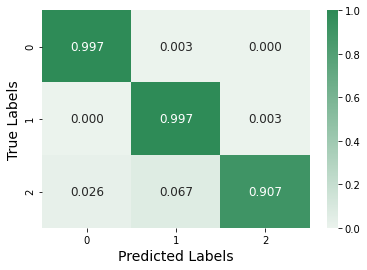

In [74]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # The following loop runs only for 1 time as the batch size for test loader is the size of number of test images only
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]

    confmat, df, macrof1, acc, plt = performance_metrics_multiclass(predicted.to('cpu').numpy(), labels.to('cpu').numpy(), num_classes)
    print(confmat)
    print(df)
    print('macroF1 = {}, accuracy = {}'.format(macrof1, acc))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(len(test_loader.dataset) ,(correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')


  ##Performance metrics


GRAPH PLOTS


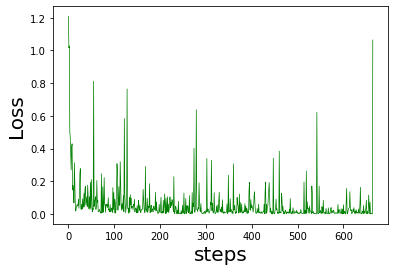

In [75]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.7 )
plt.xlabel('steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)
# plt.plot(accuracylist, color = 'red', linewidth = 0.7)
# plt.xlim(0,700)
# plt.ylim(0,1.05)
plt.show()


# Feedforward Net with MSE Loss with no weighting

In [159]:
#  initializing the model
# model = ConvNet()
model = simplenet()
model = model.to(device)

criterion = nn.MSELoss(reduce=False)
weight = torch.tensor([1, 1, 1]).to(device).to(torch.float32)


optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [160]:
# Training the model
totalsteps = len(train_loader)
losslist = []
accuracylist = []
num_epochs = 10
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    outputs = model(images)
    # print(outputs.shape, torch.nn.functional.one_hot(labels).to(torch.float32).shape)
    loss = criterion(outputs, torch.nn.functional.one_hot(labels, num_classes=3).to(torch.float32))
    loss = (loss * weight).mean()
    losslist.append(loss.item())
    # loss = loss.to(torch.float64)

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if((i + 1) % 50 == 0):
    # if(True):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))


Epoch [1/10], Step [50/133], Loss: 0.0321, Accuracy: 96.88%
Epoch [1/10], Step [100/133], Loss: 0.0270, Accuracy: 98.44%
Epoch [2/10], Step [50/133], Loss: 0.0208, Accuracy: 96.88%
Epoch [2/10], Step [100/133], Loss: 0.0298, Accuracy: 95.31%
Epoch [3/10], Step [50/133], Loss: 0.0164, Accuracy: 98.44%
Epoch [3/10], Step [100/133], Loss: 0.0280, Accuracy: 96.88%
Epoch [4/10], Step [50/133], Loss: 0.0200, Accuracy: 98.44%
Epoch [4/10], Step [100/133], Loss: 0.0190, Accuracy: 98.44%
Epoch [5/10], Step [50/133], Loss: 0.0089, Accuracy: 100.00%
Epoch [5/10], Step [100/133], Loss: 0.0313, Accuracy: 92.19%
Epoch [6/10], Step [50/133], Loss: 0.0095, Accuracy: 100.00%
Epoch [6/10], Step [100/133], Loss: 0.0256, Accuracy: 96.88%
Epoch [7/10], Step [50/133], Loss: 0.0112, Accuracy: 100.00%
Epoch [7/10], Step [100/133], Loss: 0.0204, Accuracy: 98.44%
Epoch [8/10], Step [50/133], Loss: 0.0216, Accuracy: 98.44%
Epoch [8/10], Step [100/133], Loss: 0.0201, Accuracy: 96.88%
Epoch [9/10], Step [50/133], 

[[0.99796 0.00204 0.     ]
 [0.01327 0.98468 0.00204]
 [0.18163 0.19612 0.62206]]
  class  Precision   Recall       F1
0     0    0.83661  0.99796  0.91019
1     1    0.83247  0.98468  0.90220
2     2    0.99673  0.62206  0.76604
macroF1 = 0.85948, accuracy = 0.86828
Test Accuracy for 2938 test images = 86.82777399591559 %


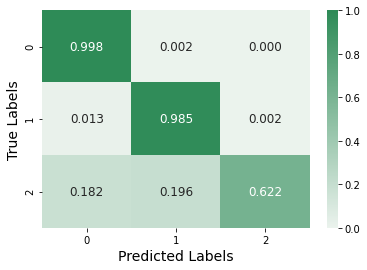

In [161]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # The following loop runs only for 1 time as the batch size for test loader is the size of number of test images only
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]

    confmat, df, macrof1, acc, plt = performance_metrics_multiclass(predicted.to('cpu').numpy(), labels.to('cpu').numpy(), num_classes)
    print(confmat)
    print(df)
    print('macroF1 = {}, accuracy = {}'.format(macrof1, acc))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(len(test_loader.dataset) ,(correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')


  ##Performance metrics


GRAPH PLOTS


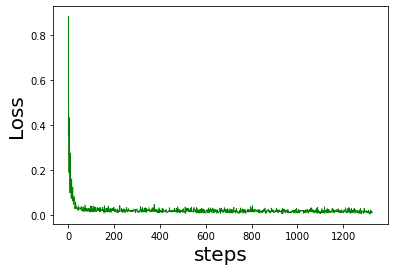

In [162]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.7 )
plt.xlabel('steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)
# plt.plot(accuracylist, color = 'red', linewidth = 0.7)
# plt.xlim(0,700)
# plt.ylim(0,1.05)
plt.show()


# Feedforward Net with MSE Loss . Class with less samples given proportionally more weight

In [163]:
#  initializing the model
# model = ConvNet()
model = simplenet()
model = model.to(device)

criterion = nn.MSELoss(reduce=False)
weight = torch.tensor([1, 1, 1]).to(device).to(torch.float32)
weight[1], weight[2] = 14/5, 20

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [164]:
# Training the model
totalsteps = len(train_loader)
losslist = []
accuracylist = []
num_epochs = 10
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    outputs = model(images)
    # print(outputs.shape, torch.nn.functional.one_hot(labels).to(torch.float32).shape)
    loss = criterion(outputs, torch.nn.functional.one_hot(labels, num_classes=3).to(torch.float32))
    loss = (loss * weight).mean()
    losslist.append(loss.item())
    # loss = loss.to(torch.float64)

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if((i + 1) % 50 == 0):
    # if(True):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))


Epoch [1/10], Step [50/133], Loss: 0.2057, Accuracy: 100.00%
Epoch [1/10], Step [100/133], Loss: 0.1845, Accuracy: 96.88%
Epoch [2/10], Step [50/133], Loss: 0.2487, Accuracy: 98.44%
Epoch [2/10], Step [100/133], Loss: 0.2021, Accuracy: 96.88%
Epoch [3/10], Step [50/133], Loss: 0.2134, Accuracy: 98.44%
Epoch [3/10], Step [100/133], Loss: 0.1442, Accuracy: 96.88%
Epoch [4/10], Step [50/133], Loss: 0.2436, Accuracy: 98.44%
Epoch [4/10], Step [100/133], Loss: 0.2098, Accuracy: 95.31%
Epoch [5/10], Step [50/133], Loss: 0.0832, Accuracy: 98.44%
Epoch [5/10], Step [100/133], Loss: 0.1238, Accuracy: 100.00%
Epoch [6/10], Step [50/133], Loss: 0.0722, Accuracy: 100.00%
Epoch [6/10], Step [100/133], Loss: 0.1700, Accuracy: 98.44%
Epoch [7/10], Step [50/133], Loss: 0.1081, Accuracy: 100.00%
Epoch [7/10], Step [100/133], Loss: 0.1256, Accuracy: 100.00%
Epoch [8/10], Step [50/133], Loss: 0.1963, Accuracy: 96.88%
Epoch [8/10], Step [100/133], Loss: 0.0694, Accuracy: 100.00%
Epoch [9/10], Step [50/133

[[0.99796 0.00204 0.     ]
 [0.00918 0.98672 0.00409]
 [0.14286 0.16854 0.68846]]
  class  Precision   Recall       F1
0     0    0.86779  0.99796  0.92833
1     1    0.85260  0.98672  0.91477
2     2    0.99410  0.68846  0.81352
macroF1 = 0.88554, accuracy = 0.89108
Test Accuracy for 2938 test images = 89.10823689584751 %


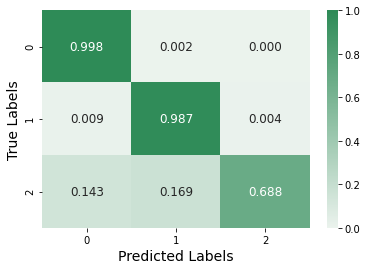

In [165]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # The following loop runs only for 1 time as the batch size for test loader is the size of number of test images only
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]

    confmat, df, macrof1, acc, plt = performance_metrics_multiclass(predicted.to('cpu').numpy(), labels.to('cpu').numpy(), num_classes)
    print(confmat)
    print(df)
    print('macroF1 = {}, accuracy = {}'.format(macrof1, acc))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(len(test_loader.dataset) ,(correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')


  ##Performance metrics


GRAPH PLOTS


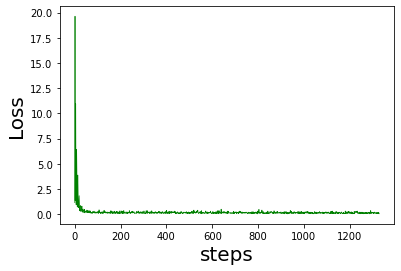

In [166]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.7 )
plt.xlabel('steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)
# plt.plot(accuracylist, color = 'red', linewidth = 0.7)
# plt.xlim(0,700)
# plt.ylim(0,1.05)
plt.show()


# Feedforward Net with MSE Loss . Focal Loss is used
$$E_n = (1-\beta^n)/(1-\beta)$$
and then 
$$W_n = 1/E_n$$

$$\beta$$ is geerally 0.9, 0.99

In [172]:
#  initializing the model
# model = ConvNet()
model = simplenet()
model = model.to(device)
beta = 0.99
criterion = nn.MSELoss(reduce=False)
weight = torch.tensor([1, 1, 1]).to(device).to(torch.float32)
weight[0], weight[1], weight[2] = (1-beta)/(1-beta**(5923)), (1-beta)/(1-beta**(2114)), (1-beta)/(1-beta**(422))

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [173]:
# Training the model
totalsteps = len(train_loader)
losslist = []
accuracylist = []
num_epochs = 10
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    # FORWARD PROP, model(images) automatically calls forward
    outputs = model(images)
    # print(outputs.shape, torch.nn.functional.one_hot(labels).to(torch.float32).shape)
    loss = criterion(outputs, torch.nn.functional.one_hot(labels, num_classes=3).to(torch.float32))
    loss = (loss * weight).mean()
    losslist.append(loss.item())
    # loss = loss.to(torch.float64)

    # BACK PROP
    # make the gradients zero
    optimizer.zero_grad() 
    # perform the backward propagation and get the gradients
    loss.backward()
    # adam optimizer training step . We use the gradients in this step
    optimizer.step()

    # Accuracy
    # Note we take batch_size amounts of y's at a time
    total = labels.size(0)
    predicted = torch.max(outputs.data,1)[1]
    correct = (predicted == labels).sum().item()
    accuracy = correct / total
    accuracylist.append(accuracy)

    # item() is used for getting the scalar from a tensor
    if((i + 1) % 50 == 0):
    # if(True):
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i+1, totalsteps, loss.item(),(accuracy)*100 ))


Epoch [1/10], Step [50/133], Loss: 0.0002, Accuracy: 98.44%
Epoch [1/10], Step [100/133], Loss: 0.0001, Accuracy: 100.00%
Epoch [2/10], Step [50/133], Loss: 0.0002, Accuracy: 100.00%
Epoch [2/10], Step [100/133], Loss: 0.0002, Accuracy: 98.44%
Epoch [3/10], Step [50/133], Loss: 0.0002, Accuracy: 98.44%
Epoch [3/10], Step [100/133], Loss: 0.0002, Accuracy: 98.44%
Epoch [4/10], Step [50/133], Loss: 0.0001, Accuracy: 98.44%
Epoch [4/10], Step [100/133], Loss: 0.0001, Accuracy: 100.00%
Epoch [5/10], Step [50/133], Loss: 0.0001, Accuracy: 100.00%
Epoch [5/10], Step [100/133], Loss: 0.0001, Accuracy: 98.44%
Epoch [6/10], Step [50/133], Loss: 0.0002, Accuracy: 96.88%
Epoch [6/10], Step [100/133], Loss: 0.0003, Accuracy: 93.75%
Epoch [7/10], Step [50/133], Loss: 0.0001, Accuracy: 98.44%
Epoch [7/10], Step [100/133], Loss: 0.0002, Accuracy: 98.44%
Epoch [8/10], Step [50/133], Loss: 0.0002, Accuracy: 95.31%
Epoch [8/10], Step [100/133], Loss: 0.0002, Accuracy: 98.44%
Epoch [9/10], Step [50/133],

[[0.99796 0.00204 0.     ]
 [0.00816 0.98774 0.00409]
 [0.14184 0.15015 0.70787]]
  class  Precision   Recall       F1
0     0    0.86933  0.99796  0.92921
1     1    0.86649  0.98774  0.92315
2     2    0.99426  0.70787  0.82697
macroF1 = 0.89311, accuracy = 0.89789
Test Accuracy for 2938 test images = 89.78897208985704 %


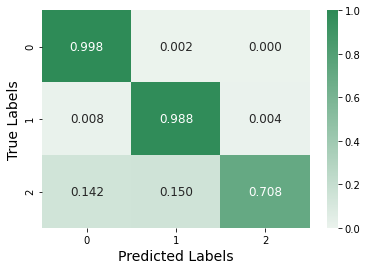

In [174]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  # The following loop runs only for 1 time as the batch size for test loader is the size of number of test images only
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.max(outputs.data,1)[1]

    confmat, df, macrof1, acc, plt = performance_metrics_multiclass(predicted.to('cpu').numpy(), labels.to('cpu').numpy(), num_classes)
    print(confmat)
    print(df)
    print('macroF1 = {}, accuracy = {}'.format(macrof1, acc))
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy for {} test images = {} %'.format(len(test_loader.dataset) ,(correct/total)*100))

  # torch.save(model.state_dict(), './MODEL_STORE/MNIST_conve_nets.ckpt')


  ##Performance metrics


GRAPH PLOTS


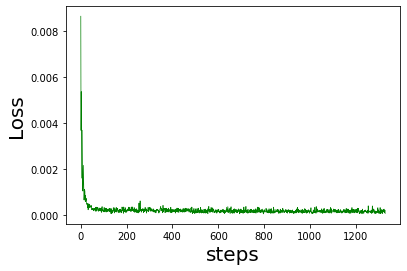

In [175]:
import matplotlib.pyplot as plt
plt.plot(losslist, color = 'green', linewidth = 0.7 )
plt.xlabel('steps', fontsize=20)
plt.ylabel('Loss', fontsize=20)
# plt.plot(accuracylist, color = 'red', linewidth = 0.7)
# plt.xlim(0,700)
# plt.ylim(0,1.05)
plt.show()
